### Import Libraries

In [1]:
# Standard libraries
import csv
import json
import os
import re
import shutil

# Data processing and analysis
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score,confusion_matrix, f1_score, recall_score, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Image processing and OCR
from PIL import Image, ImageDraw
import cv2
import pytesseract

# Transformers and huggingface_hub
from huggingface_hub import hf_hub_download
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection
from paddleocr import PaddleOCR, draw_ocr

# PyTorch
import torch


c:\Users\nick2\anaconda3\envs\Test_Env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Working Directory and Program Locations

In [ ]:
# Constants
DATA_PATH = 'C:/Users/nick2/Desktop/Capstone TT/Geological-Report-Similarity-Analysis' ## Path To Repository 
TESSERACT_PATH = r'C:/Program Files/Tesseract-OCR/tesseract' ## Path To Tesseract OCR - See README For Setup 

# Read the CSV file into a DataFrame
test_labels = pd.read_csv(os.path.join(DATA_PATH, 'Capstone Project - Table Text Extraction/Labeled Data.csv'))
test_labels['Pred'] = None

# Set working directory
working_directory = os.path.join(DATA_PATH, 'WAMEX_DATA_EXTRACTED')
os.chdir(working_directory)

# Set tesseract path
pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

# List all files and get their full paths
files = os.listdir()
concatenated_paths = [os.path.join(working_directory, filename) for filename in files]

# 1. Table Detection

In [3]:
VALID_EXTENSIONS = {'.jpg', '.png'}
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]
]

# Define Model and Feature Extractor
feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

# Functions
def get_valid_images(directory):
    """Get valid image files from a directory."""
    all_files = [os.path.join(directory, file) for file in os.listdir(directory)
                 if os.path.isfile(os.path.join(directory, file))
                 and os.path.splitext(file)[1].lower() in VALID_EXTENSIONS]
    return all_files


def move_jpg_to_extracted_folder(directory):
    """Move all JPG files in a directory to a sub-directory named 'jpg_extracted'."""
    jpg_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.lower().endswith('.jpg')]
    
    # Create 'jpg_extracted' sub-directory if it doesn't exist
    extracted_folder = os.path.join(directory, "jpg_extracted")
    if not os.path.exists(extracted_folder):
        os.makedirs(extracted_folder)

    # Move each JPG file to the 'jpg_extracted' folder
    for jpg_file in jpg_files:
        shutil.move(os.path.join(directory, jpg_file), os.path.join(extracted_folder, jpg_file))



def process_directory(directory, plot=False):
    """Process all valid images in a directory and return a DataFrame."""
    print(f"Processing images in directory: {os.path.basename(directory)}")
    
    all_files = get_valid_images(directory)
    all_data = []
    
    for image_file in all_files:
        data = process_image(image_file, base_save_path=directory, plot=plot)
        if data:
            all_data.append(data)

    # Move the JPG files to the 'jpg_extracted' folder after processing
    move_jpg_to_extracted_folder(directory)
    
    return pd.DataFrame(all_data)


def process_image(file_name, base_save_path, buffer=30, plot=True):
    base_file_name = os.path.basename(file_name).rsplit('.', 1)[0]
    file_parts = base_file_name.split('_')
    
    image = Image.open(file_name).convert("RGB")
    img_cv = cv2.imread(file_name)
    width, height = image.size
    encoding = feature_extractor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**encoding)

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.94, target_sizes=[(height, width)])[0]
    num_tables = len(results['scores'])

    boxes = results['boxes'] # Direct extraction from results
    if len(boxes) > 0:
        specific_save_path = os.path.join(base_save_path, f"{base_file_name} Cropped Images")
        if not os.path.exists(specific_save_path):
            os.makedirs(specific_save_path)

        for index, box in enumerate(boxes):
            x1 = int(box[0])
            y1 = int(box[1])
            x2 = int(box[2])
            y2 = int(box[3])
            
            # Adjust the buffer for x1 and x2 (wideness) by 1.2 times
            x1 = max(0, x1 - int(1.2 * buffer))
            y1 = max(0, y1 - buffer)
            x2 = min(img_cv.shape[1], x2 + int(4.5 * buffer))
            y2 = min(img_cv.shape[0], y2 + buffer)

            
            cropped_img = img_cv[y1:y2, x1:x2]
            cv2.imwrite(f"{specific_save_path}/{base_file_name}_table_{index}.png", cropped_img)

    if plot and num_tables > 0:
        plot_results(image, results['scores'], results['labels'], results['boxes'])

    if len(file_parts) == 2:
        return {'FileName': file_parts[0], 'Page Number': file_parts[1], 'Number of tables': num_tables}
    else:
        return None

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

# Main execution
all_data = []

for path in concatenated_paths:
    if os.path.isdir(path):
        df = process_directory(path, plot=False)
        all_data.append(df)
    elif os.path.isfile(path) and os.path.splitext(path)[1].lower() in VALID_EXTENSIONS:
        parent_dir = os.path.dirname(path)  # This is where our cropped images would be saved
        data = process_image(path, base_save_path=parent_dir, plot=False)
        if data:
            all_data.append(pd.DataFrame([data]))

# Concatenate all data into the master dataframe
master_df = pd.concat(all_data, ignore_index=True)

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing images in directory: 132241
Processing images in directory: 132302
Processing images in directory: 132577
Processing images in directory: 134934
Processing images in directory: 135347


## 1.2 Evaluation of Table Prediction Accuracy

In [ ]:
# Read your DataFrame from table_counts_threshold_099.csv

eval_path = DATA_PATH+'/'+'Capstone Project - Table Text Extraction/table_counts_threshold_099.csv'

df = pd.read_csv(eval_path)

# Define the subset size (number of rows per subset)
subset_size = 480  # 480 rows

# Calculate the number of subsets to create
num_subsets = len(df) // subset_size

# Define the subset index to display the confusion matrix (6th subset)
display_subset_index = 5  # Indexing starts from 0

# Iterate through subsets and calculate performance metrics
for i in range(num_subsets):
    # Calculate the starting and ending indices for the current subset
    start_idx = i * subset_size
    end_idx = (i + 1) * subset_size

    # Extract the subset of the DataFrame
    subset_df = df.iloc[start_idx:end_idx]

    # Extract the "Table Detected (Model)" and "Table Detected (Human)" columns for this subset
    model_detected = subset_df['Table Detected (Model)']
    human_detected = subset_df['Table Detected (Human)']

    # Filter out any detections over 3 (replace values greater than 3 with 3)
    model_detected = np.minimum(model_detected, 3)
    human_detected = np.minimum(human_detected, 3)

    # Calculate and save accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(human_detected, model_detected)
    precision = precision_score(human_detected, model_detected, average='weighted', zero_division=0)
    recall = recall_score(human_detected, model_detected, average='weighted', zero_division=0)
    f1 = f1_score(human_detected, model_detected, average='weighted', zero_division=0)

    # Display the start and end rows for this subset
    subset_title = 0.9 + i / 100  # Convert index to subset title
    print(f'Subset {subset_title:.2f} - Start Row: {start_idx + 1}, End Row: {end_idx}')
    print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

    # Check if this is the 6th subset (display_subset_index)
    if i == display_subset_index:
        # Create the confusion matrix for this subset
        confusion = confusion_matrix(human_detected, model_detected)

        # Define class labels for the confusion matrix (0 to 3)
        class_labels_subset = ['0', '1', '2', '3']

        # Create a confusion matrix visualization using ConfusionMatrixDisplay with specified labels
        disp = ConfusionMatrixDisplay(confusion, display_labels=class_labels_subset)
        disp.plot(cmap=plt.cm.Blues, values_format='d')

        plt.title(f'Count Confusion Matrix for Subset {subset_title:.2f}')
        plt.show()
        plt.close()




In [ ]:

# Define the subset size (number of rows per subset)
subset_size = 480  # 480 rows

# Calculate the number of subsets to create
num_subsets = len(df) // subset_size

# Define a variable for renaming subsets
subset_name = 0.90

# Initialize lists to store count and percentage values
detected_counts = []
none_counts = []
equal_counts = []
less_counts = []
more_counts = []
more_misclassified_counts = []

# Iterate through subsets and calculate count and percentage values
for i in range(num_subsets):
    # Calculate the starting and ending indices for the current subset
    start_idx = i * subset_size
    end_idx = (i + 1) * subset_size

    # Extract the subset of the DataFrame
    subset_df = df.iloc[start_idx:end_idx]

    # Extract the "Table Detected (Model)" and "Table Detected (Human)" columns for this subset
    model_detected = subset_df['Table Detected (Model)']
    human_detected = subset_df['Table Detected (Human)']

    # Calculate the count of 'Detected' and 'None' classes
    detected_count = ((model_detected > 0) & (human_detected > 0)).sum()
    none_count = ((model_detected == 0) & (human_detected == 0)).sum()

    # Calculate the count of 'Equal,' 'Less,' and 'More' classes
    equal_count = ((model_detected == human_detected) & (model_detected > 0) & (human_detected > 0)).sum()  # Added condition
    less_count = ((model_detected < human_detected) & ((model_detected > 0) | (human_detected > 0))).sum()
    more_count = ((model_detected > 0) & (human_detected > 0)).sum()  # Modified to consider only both > 0
    more_misclassified_count = ((model_detected > human_detected) & (human_detected == 0) & (model_detected > 0)).sum()

    # Append the count values to the respective lists
    detected_counts.append(detected_count)
    none_counts.append(none_count)
    equal_counts.append(equal_count)
    less_counts.append(less_count)
    more_counts.append(more_count)
    more_misclassified_counts.append(more_misclassified_count)

    # Calculate percentages
    total_samples = len(subset_df)
    detected_percentage = (detected_count / total_samples) * 100
    none_percentage = (none_count / total_samples) * 100
    equal_percentage = (equal_count / total_samples) * 100
    less_percentage = (less_count / total_samples) * 100
    more_percentage = (more_count / total_samples) * 100
    more_misclassified_percentage = (more_misclassified_count / total_samples) * 100

    # Create strings for printing
    count_and_percentage_strings = []
    count_and_percentage_strings.append(f"Subset {subset_name:.2f}:")
    count_and_percentage_strings.append(f"  Detected: {detected_count}, Detected%: {detected_percentage:.2f}%")
    count_and_percentage_strings.append(f"  None: {none_count}, None%: {none_percentage:.2f}%")
    count_and_percentage_strings.append(f"  Equal: {equal_count}, Equal%: {equal_percentage:.2f}%")
    count_and_percentage_strings.append(f"  Less: {less_count}, Less%: {less_percentage:.2f}%")
    count_and_percentage_strings.append(f"  More: {more_count}, More%: {more_percentage:.2f}%")
    count_and_percentage_strings.append(f"  More Misclassified: {more_misclassified_count}, More Misclassified%: {more_misclassified_percentage:.2f}%")

    # Print count and percentage strings
    for line in count_and_percentage_strings:
        print(line)

    # Increment the subset name
    subset_name += 0.01

# Create four subplots (two for counts and two for percentages) with the original size
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Larger plot size
fig.suptitle('Count and Percentage of Classes in Subsets', fontsize=16)


# Subplot for counts of 'Detected' and 'None' classes
x = np.arange(len(detected_counts))
bars_det = axes[0, 0].bar(x, detected_counts, label='Detected', alpha=0.5)
bars_none = axes[0, 0].bar(x, none_counts, label='None', alpha=0.5, bottom=detected_counts)
axes[0, 0].set_xlabel('Subsets')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Count of Detected and None Classes')
axes[0, 0].set_xticks(x)
axes[0, 0].legend(loc='upper right')  # Legend placed outside the plot
axes[0, 0].set_xticklabels([f"Subset {subset_name:.2f}" for subset_name in np.arange(0.90, 0.90 + num_subsets * 0.01, 0.01)], rotation=45)

# Add labels on the bars for counts of 'Detected' and 'None' classes
for bar_det, bar_none, label_det, label_none in zip(bars_det, bars_none, detected_counts, none_counts):
    height_det = bar_det.get_height()
    height_none = bar_none.get_height()
    axes[0, 0].annotate(f'{label_det}', xy=(bar_det.get_x() + bar_det.get_width() / 2, height_det / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[0, 0].annotate(f'{label_none}', xy=(bar_none.get_x() + bar_none.get_width() / 2, height_det + height_none / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Subplot for percentages of 'Detected' and 'None' classes
x = np.arange(len(detected_counts))
detected_percentages = [(count / (count + none_counts[i])) * 100 for i, count in enumerate(detected_counts)]
none_percentages = [(count / (count + detected_counts[i])) * 100 for i, count in enumerate(none_counts)]

bars_det = axes[0, 1].bar(x, detected_percentages, label='Detected (%)', alpha=0.5)
bars_none = axes[0, 1].bar(x, none_percentages, label='None (%)', alpha=0.5, bottom=detected_percentages)
axes[0, 1].set_xlabel('Subsets')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].set_title('Percentage of Detected and None Classes')
axes[0, 1].set_xticks(x)
axes[0, 1].legend(loc='upper right')  # Legend placed outside the plot
axes[0, 1].set_xticklabels([f"Subset {subset_name:.2f}" for subset_name in np.arange(0.90, 0.90 + num_subsets * 0.01, 0.01)], rotation=45)

# Add labels on the bars for percentages of 'Detected' and 'None' classes
for bar_det, bar_none, label_det, label_none in zip(bars_det, bars_none, detected_percentages, none_percentages):
    height_det = bar_det.get_height()
    height_none = bar_none.get_height()
    axes[0, 1].annotate(f'{label_det:.2f}%', xy=(bar_det.get_x() + bar_det.get_width() / 2, height_det / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[0, 1].annotate(f'{label_none:.2f}%', xy=(bar_none.get_x() + bar_none.get_width() / 2, height_det + height_none / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Subplot for counts of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
x = np.arange(len(equal_counts))
bars_equal = axes[1, 0].bar(x, equal_counts, label='Equal', alpha=0.5)
bars_less = axes[1, 0].bar(x, less_counts, label='Less', alpha=0.5, bottom=equal_counts)
bars_more = axes[1, 0].bar(x, more_counts, label='More', alpha=0.5, bottom=np.array(equal_counts) + np.array(less_counts))
bars_more_misclassified = axes[1, 0].bar(x, more_misclassified_counts, label='More Misclassified', alpha=0.5,
                                          bottom=np.array(equal_counts) + np.array(less_counts) + np.array(more_counts))
axes[1, 0].set_xlabel('Subsets')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Count of Equal, Less, More, and More Misclassified Classes')
axes[1, 0].set_xticks(x)
axes[1, 0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend placed outside to the right

# Add labels on the bars for counts of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
for bar_equal, bar_less, bar_more, bar_more_misclassified, label_equal, label_less, label_more, label_more_misclassified in zip(
        bars_equal, bars_less, bars_more, bars_more_misclassified, equal_counts, less_counts, more_counts, more_misclassified_counts):
    height_equal = bar_equal.get_height()
    height_less = bar_less.get_height()
    height_more = bar_more.get_height()
    height_more_misclassified = bar_more_misclassified.get_height()
    axes[1, 0].annotate(f'{label_equal}', xy=(bar_equal.get_x() + bar_equal.get_width() / 2, height_equal / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_less}', xy=(bar_less.get_x() + bar_less.get_width() / 2, height_equal + height_less / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_more}', xy=(bar_more.get_x() + bar_more.get_width() / 2, height_equal + height_less + height_more / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    axes[1, 0].annotate(f'{label_more_misclassified}', xy=(bar_more_misclassified.get_x() + bar_more_misclassified.get_width() / 2,
                                                           height_equal + height_less + height_more + height_more_misclassified / 2),
                       xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Subplot for percentages of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
x = np.arange(len(equal_counts))
equal_percentages = [(count / (count + less_counts[i] + more_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(equal_counts)]
less_percentages = [(count / (count + equal_counts[i] + more_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(less_counts)]
more_percentages = [(count / (count + equal_counts[i] + less_counts[i] + more_misclassified_counts[i])) * 100 for i, count in enumerate(more_counts)]
more_misclassified_percentages = [(count / (count + equal_counts[i] + less_counts[i] + more_counts[i])) * 100 for i, count in enumerate(more_misclassified_counts)]

bars_equal = axes[1, 1].bar(x, equal_percentages, label='Equal (%)', alpha=0.5)
bars_less = axes[1, 1].bar(x, less_percentages, label='Less (%)', alpha=0.5, bottom=equal_percentages)
bars_more = axes[1, 1].bar(x, more_percentages, label='More (%)', alpha=0.5,
                          bottom=np.array(equal_percentages) + np.array(less_percentages))
bars_more_misclassified = axes[1, 1].bar(x, more_misclassified_percentages, label='More Misclassified (%)', alpha=0.5,
                                          bottom=np.array(equal_percentages) + np.array(less_percentages) + np.array(more_percentages))
axes[1, 1].set_xlabel('Subsets')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('Percentage of Equal, Less, More, and More Misclassified Classes')
axes[1, 1].set_xticks(x)
axes[1, 1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Legend placed outside to the right

# Add labels on the bars for percentages of 'Equal,' 'Less,' 'More,' and 'More Misclassified' classes
for bar_equal, bar_less, bar_more, bar_more_misclassified, label_equal, label_less, label_more, label_more_misclassified in zip(
        bars_equal, bars_less, bars_more, bars_more_misclassified, equal_percentages, less_percentages, more_percentages, more_misclassified_percentages):
    height_equal = bar_equal.get_height()
    height_less = bar_less.get_height()
    height_more = bar_more.get_height()
    height_more_misclassified = bar_more_misclassified.get_height()
    axes[1, 1].annotate(f'{label_equal:.2f}%', xy=(bar_equal.get_x() + bar_equal.get_width() / 2, height_equal / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_less:.2f}%', xy=(bar_less.get_x() + bar_less.get_width() / 2, height_equal + height_less / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_more:.2f}%', xy=(bar_more.get_x() + bar_more.get_width() / 2, height_equal + height_less + height_more / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')
    axes[1, 1].annotate(f'{label_more_misclassified:.2f}%',
                       xy=(bar_more_misclassified.get_x() + bar_more_misclassified.get_width() / 2,
                           height_equal + height_less + height_more + height_more_misclassified / 2),
                       xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2.1 Perform Table Data Extraction Using Morphological Operations Tesseract

In [4]:
# Search Functions
def find_subdirs_with_name(path, keyword):
    """Return all subdirectories containing the given keyword."""
    return [os.path.join(root, directory) for root, dirs, files in os.walk(path) for directory in dirs if keyword in directory]

def find_image_files_in_dir(path):
    """Return all image files in the directory."""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    return [os.path.join(root, file) for root, dirs, files in os.walk(path) for file in files if any(file.lower().endswith(ext) for ext in image_extensions)]

In [6]:

def process_image(image_path):
    image = cv2.imread(image_path, 0)
    
    img_bin = 255 - image
    _, img_bin_otsu = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Vertical Line extraction
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img_bin_otsu).shape[1]//150))
    eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=5)
    vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=5)
    
    # Horizontal Line extraction
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img_bin_otsu).shape[1]//150, 1))
    image_2 = cv2.erode(img_bin_otsu, hor_kernel, iterations=5)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=5)

    # Combining
    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)
    _, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    b_image = cv2.bitwise_not(cv2.bitwise_xor(image, vertical_horizontal_lines))
    return b_image, vertical_horizontal_lines


def extract_bounding_boxes(b_image, vertical_horizontal_lines):
    contours, _ = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda x: x[1][1]))

    boxes = []
    image_copy = b_image.copy()  # Initialize image_copy here
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x-=1
        w+=1
        if w < 1000 and h < 500:
            cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 255), 1)
            boxes.append([x, y, w, h])
            
    # Uncomment Section to show plots
    # plt.imshow(image_copy, cmap='gray')
    # plt.title("Identified contours")
    # plt.show()
    return boxes

def extract_text_from_boxes(b_image, boxes):
    rows = []
    columns = []
    heights = [box[3] for box in boxes]  # Extracting the heights of all boxes
    mean_height = np.mean(heights)

    # Initialize columns list with the first box and set the previous box to the first box
    columns.append(boxes[0])
    previous_box = boxes[0]

    for i in range(1, len(boxes)):
        if boxes[i][1] <= previous_box[1] + mean_height / 2:
            columns.append(boxes[i])
            previous_box = boxes[i]
            if i == len(boxes) - 1:
                rows.append(columns)
        else:
            rows.append(columns)
            columns = []
            previous_box = boxes[i]
            columns.append(boxes[i])

    # Determine the total number of cells in the row with the maximum cells
    total_cells = max([len(r) for r in rows])

    # Find the center of each box in the first row
    centers = [int(rows[0][j][0] + rows[0][j][2] / 2) for j in range(len(rows[0]))]
    centers = np.array(centers)
    centers.sort()

    # Organize boxes by their closest center position
    boxes_list = []
    for i in range(len(rows)):
        l = [[] for _ in range(total_cells)]
        for j in range(len(rows[i])):
            # Find the closest center for the current box
            diff = abs(centers - (rows[i][j][0] + rows[i][j][2] / 4))
            minimum = min(diff)
            index = list(diff).index(minimum)
            l[index].append(rows[i][j])
        boxes_list.append(l)

    # Extracting text from cells in the image
    dataframe_final = []
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            s = ''
            if len(boxes_list[i][j]) == 0:
                dataframe_final.append(' ')
            else:
                for k in range(len(boxes_list[i][j])):
                    x, y, w, h = boxes_list[i][j][k]
                    roi = b_image[y:y+h, x:x+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(roi, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=[255, 255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel, iterations=1)
                    erosion = cv2.erode(dilation, kernel, iterations=2)
                    out = pytesseract.image_to_string(erosion).strip()
                    s += " " + out
                dataframe_final.append(s)

    arr = np.array(dataframe_final)
    dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))

    return dataframe

def ocr_image_to_text(image_path, extracted_dir):
    b_image, vertical_horizontal_lines = process_image(image_path)
    boxes = extract_bounding_boxes(b_image, vertical_horizontal_lines)

    if len(boxes) <= 1:
        print("No Table Detected.")
        return  # No need to return the counter
    else:
        print('Table Extracted!')
        dataframe = extract_text_from_boxes(b_image, boxes)
        
        # Changed this line to set output directory as the extracted_dir itself
        output_dir = extracted_dir
        
        # Removed the redundant "Cropped Images" replacement
        file_name_without_ext = os.path.basename(image_path).rsplit('.', 1)[0]
        
        csv_output_path = os.path.join(output_dir, f"{file_name_without_ext}.csv")
        
        dataframe.to_csv(csv_output_path, index=False, header=False)


def process_images_in_extracted_dirs(main_wd, output_dir):
    cropped_dirs = find_subdirs_with_name(main_wd, "Cropped")
    for extracted_dir in cropped_dirs:
        for image_path in find_image_files_in_dir(extracted_dir):
            ocr_image_to_text(image_path, extracted_dir)


## Use of Extractor
main_wd = working_directory
output_directory = os.path.dirname(main_wd)
process_images_in_extracted_dirs(main_wd, output_directory)


Table Extracted!
Table Extracted!
No Table Detected.
No Table Detected.
No Table Detected.
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
Table Extracted!
No Table Detected.
Table Extracted!


KeyboardInterrupt: 

# 2.2 Perform Table Data Extraction Using Paddle OCR

[2023/10/19 22:17:52] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\nick2/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

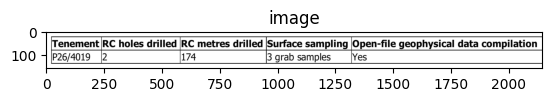

[2023/10/19 22:18:09] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:18:09] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.25075483322143555
[2023/10/19 22:18:09] ppocr DEBUG: rec_res num  : 6, elapsed : 0.18505287170410156
[2023/10/19 22:18:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh

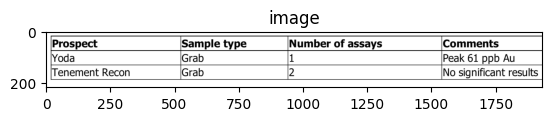

[2023/10/19 22:18:18] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:18:18] ppocr DEBUG: dt_boxes num : 12, elapsed : 0.30544090270996094
[2023/10/19 22:18:19] ppocr DEBUG: rec_res num  : 12, elapsed : 0.8942103385925293
[2023/10/19 22:18:19] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thres

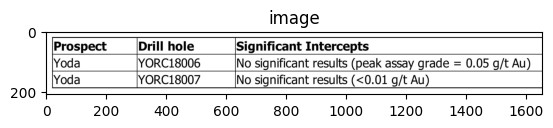

[2023/10/19 22:18:28] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:18:28] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.3610250949859619
[2023/10/19 22:18:29] ppocr DEBUG: rec_res num  : 9, elapsed : 0.8560914993286133
[2023/10/19 22:18:29] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0

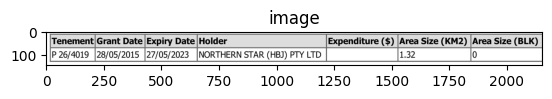

[2023/10/19 22:18:37] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:18:38] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.30859375
[2023/10/19 22:18:38] ppocr DEBUG: rec_res num  : 7, elapsed : 0.19495820999145508
[2023/10/19 22:18:38] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, de

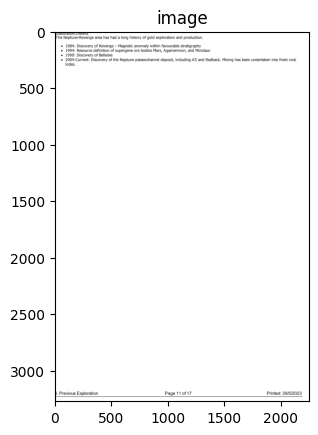

[2023/10/19 22:18:47] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:18:48] ppocr DEBUG: dt_boxes num : 11, elapsed : 0.3093760013580322
[2023/10/19 22:18:49] ppocr DEBUG: rec_res num  : 11, elapsed : 0.9531295299530029
[2023/10/19 22:18:49] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\nick2/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.5, det_db_unclip_ratio=1.2, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh

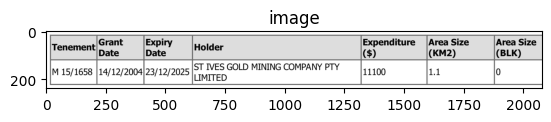

[2023/10/19 22:19:06] ppocr WARNING: Since the angle classifier is not initialized, it will not be used during the forward process
[2023/10/19 22:19:07] ppocr DEBUG: dt_boxes num : 19, elapsed : 0.4258742332458496
[2023/10/19 22:19:09] ppocr DEBUG: rec_res num  : 19, elapsed : 2.346318483352661


In [37]:
# Instantiate PaddleOCR
ocr = PaddleOCR(
    use_gpu=True,
    det_db_thresh=0.3,
    det_db_box_thresh=0.5,
    det_db_unclip_ratio=1.2
)

# Function to process the image
def process_image(image_path):
    image = cv2.imread(image_path, 0)

    img_bin = 255 - image
    _, img_bin_otsu = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Vertical Line extraction
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, img_bin_otsu.shape[1] // 35))
    eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=1)

    # Horizontal Line extraction
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img_bin_otsu).shape[1] // 50, 1))
    image_2 = cv2.erode(img_bin_otsu, hor_kernel, iterations=1)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=2)

    horizontal_contours, _ = cv2.findContours(horizontal_lines, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    vertical_contours, _ = cv2.findContours(vertical_lines, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    hor_lines = len(horizontal_contours)
    ver_lines = len(vertical_contours)

    if hor_lines > 1 or ver_lines > 1:

        plt.imshow(image, cmap='gray')
        plt.title("image")
        plt.show()

        return image
    else:
        return None


# Function to plot bounding boxes on the original image
def plot_boxes_on_original_image(img, bounding_boxes_list):
    img_with_boxes = img.copy()

    for bounding_boxes in bounding_boxes_list:
        top_left = bounding_boxes[0]
        bottom_right = bounding_boxes[2]

        x1, y1 = top_left
        x2, y2 = bottom_right


        # Draw the bounding box
        cv2.rectangle(img_with_boxes, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

def extract_data_from_image(img_path, ocr_instance):

    
    # Load and preprocess the image
    preprocessed_img = process_image(img_path)

    
    if preprocessed_img is None:
        
        return None
    
    else:  # Extract text using PaddleOCR
        results = ocr_instance.ocr(preprocessed_img)
        
        # Process OCR results
        result_list = [
            [result[0][0], result[0][2], result[1][0], result[1][1]]
            for result in results[0]
        ]
        
        sorted_data = sorted(result_list, key=lambda x: x[0][1])
        
        # Group results by rows based on a threshold
        threshold = 10
        rows, current_row = [], []
        for entry in sorted_data:
            if not current_row or (entry[0][1] - current_row[-1][0][1] <= threshold):
                current_row.append(entry)
            else:
                rows.append(current_row)
                current_row = [entry]
        
        if current_row:
            rows.append(current_row)
        
        # Sort and convert results to DataFrame
        table = [sorted(row, key=lambda x: x[0][0]) for row in rows]
        table_strings = [[entry[2] for entry in row] for row in table]
        df = pd.DataFrame(table_strings)
        
        return df


def process_images_in_extracted_dirs(main_wd):
    cropped_dirs = find_subdirs_with_name(main_wd, "Cropped")
    for extracted_dir in cropped_dirs:
        for image_path in find_image_files_in_dir(extracted_dir):
            # Initialize PaddleOCR instance
            ocr_instance = PaddleOCR(
                use_gpu=True,
                det_db_thresh=0.3,
                det_db_box_thresh=0.5,
                det_db_unclip_ratio=1.2
            )
            
            # Extract data from image and save as DataFrame
            df = extract_data_from_image(image_path, ocr_instance)

            if df is None:
                continue
            else:
                # Save the DataFrame to CSV in the same directory as the image
                base_filename = os.path.splitext(os.path.basename(image_path))[0]
                output_file_path = os.path.join(os.path.dirname(image_path), base_filename + ".csv")
                df.to_csv(output_file_path, index=False, header=False)


# Usage
main_wd = working_directory
output_directory = os.path.dirname(main_wd)
process_images_in_extracted_dirs(main_wd)



# 2.3 Perform Table Data Extraction Using Paddle OCR and Bounding Boxes from cv2

In [ ]:
ocr = PaddleOCR()


def threshold_image(image):
    """Thresholds the image for further processing"""
    img_bin = 255 - image
    _, img_bin_otsu = cv2.threshold(img_bin, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_bin_otsu

def extract_lines(img_bin_otsu, orient="horizontal"):
    """Extracts horizontal or vertical lines from a binarized image"""
    if orient == "horizontal":
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_bin_otsu.shape[1] // 100, 1))
    else:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, img_bin_otsu.shape[1] // 50))
    eroded_image = cv2.erode(img_bin_otsu, kernel, iterations=1) 
    return cv2.dilate(eroded_image, kernel, iterations=1)

def get_cell_locations(vertical_horizontal_lines):
    """Extracts cell locations from a combined vertical and horizontal lines image"""
    contours, _ = cv2.findContours(vertical_horizontal_lines, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cell_locations = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:
            roi = vertical_horizontal_lines[y:y+h, x:x+w]
            _, roi_bin = cv2.threshold(roi, 127, 255, cv2.THRESH_BINARY_INV)
            cell_contours, _ = cv2.findContours(roi_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cell_contour in cell_contours:
                cx, cy, cw, ch = cv2.boundingRect(cell_contour)
                cell_locations.append((x + cx, y + cy, cw, ch))

    return list(set(cell_locations))

def process_cell_region(cell_region, ocr):
    """Processes a cell region using OCR and returns extracted text"""
    results = ocr.ocr(cell_region)
    text_list = [text_info[1][0] for entry in results if entry for text_info in entry]
    return ' '.join(text_list) if text_list else '0'

def detect_cells_in_image(image_path):
    """Main function to detect cells in the image"""
    image = cv2.imread(image_path, 0)
    img_bin_otsu = threshold_image(image)
    vertical_lines = extract_lines(img_bin_otsu, "vertical")
    horizontal_lines = extract_lines(img_bin_otsu, "horizontal")
    data_t = []

    if vertical_lines.any() and horizontal_lines.any():
        vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        vertical_horizontal_lines = cv2.dilate(vertical_horizontal_lines, kernel, iterations=5)
        
        cell_locations = get_cell_locations(vertical_horizontal_lines)

        for cell in cell_locations:
            x, y, w, h = cell
            cell_region = image[y:y+h, x:x+w]
            text = process_cell_region(cell_region, ocr)
            data_t.append([text, [x, y]])

        return data_t
    else:
        return None

def bucket_data_by_rows(data, tolerance=12):
    """Group data into rows based on y-coordinates and a given tolerance."""
    rows_data = {}
    for text, coord in data:
        y = coord[1]
        for key in sorted(rows_data.keys()):
            if abs(y - key) <= tolerance:
                rows_data[key].append((text, coord))
                break
        else:  # This else corresponds to the for-loop, and will only execute if the for-loop completes without a break
            rows_data[y] = [(text, coord)]
    return rows_data

def convert_rows_to_dataframe(rows_data):
    """Convert organized rows data into a DataFrame."""
    header_row_coords = sorted(rows_data.keys())[0]
    header_positions = [item[1][0] for item in rows_data[header_row_coords]]

    df_data = []
    for key in sorted(rows_data.keys()):
        row_items = rows_data[key]
        row_data = [''] * len(header_positions)
        for text, coord in row_items:
            closest_index = min(range(len(header_positions)), key=lambda i: abs(header_positions[i]-coord[0]))
            row_data[closest_index] = text
        df_data.append(row_data)

    return pd.DataFrame(df_data)

def process_images_in_extracted_dirs(main_wd):
    cropped_dirs = find_subdirs_with_name(main_wd, "Cropped")
    for extracted_dir in cropped_dirs:
        for image_path in find_image_files_in_dir(extracted_dir):
            data = detect_cells_in_image(image_path)
            if data:
                data.sort(key=lambda x: (x[1][1], x[1][0]))
                rows_data = bucket_data_by_rows(data)
                df = convert_rows_to_dataframe(rows_data)
                df = df.astype(str)
                df = df.loc[:, df.iloc[0] != '0']
                df.replace('', np.nan, inplace=True)
                df.dropna(axis=1, how='all', inplace=True)
                
                # Save to csv
                base_filename = os.path.splitext(os.path.basename(image_path))[0]
                output_file_path = os.path.join(os.path.dirname(image_path), base_filename + ".csv")
                df.to_csv(output_file_path, index=False, header=False)
                

# Usage
process_images_in_extracted_dirs(working_directory)